## Exercise 9, Image registration

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output

#import img_as_ubyte from skimage
from skimage import img_as_ubyte

In [8]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [9]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

## Ex 1

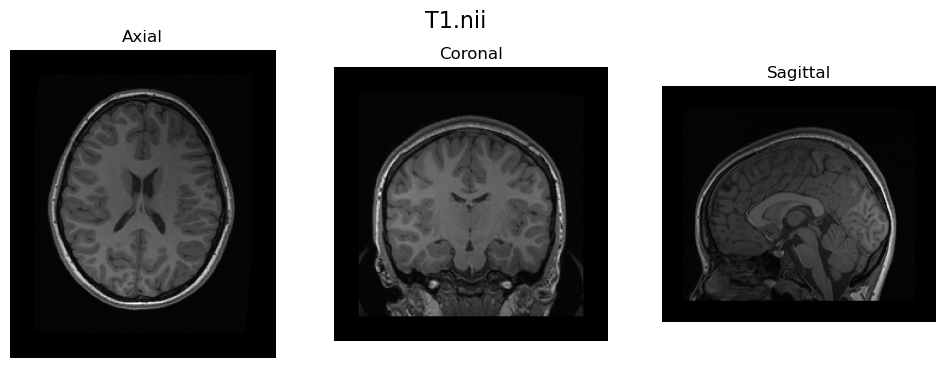

In [10]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

In [11]:
import numpy as np

def rotation_matrix(pitch, roll, yaw):
    """
    Return the rotation matrix for the given pitch, roll and yaw angles.

    Parameters
    ----------
    pitch : float
        Pitch angle in degrees.
    roll : float
        Roll angle in degrees.
    yaw : float
        Yaw angle in degrees.

    Returns
    -------
    R : ndarray
        Rotation matrix.
    """
    pitch = np.deg2rad(pitch)
    roll = np.deg2rad(roll)
    yaw = np.deg2rad(yaw)

    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch), 0],
        [0, np.sin(pitch), np.cos(pitch), 0],
        [0, 0, 0, 1]
    ])
    
    Ry = np.array([
        [np.cos(roll), 0, np.sin(roll), 0],
        [0, 1, 0, 0],
        [-np.sin(roll), 0, np.cos(roll), 0],
        [0, 0, 0, 1]
    ])
    
    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0, 0],
        [np.sin(yaw), np.cos(yaw), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    return Rx @ Ry @ Rz
    

In [12]:
affine_1 = rotation_matrix(25, 0, 0)

affine_1

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.90630779, -0.42261826,  0.        ],
       [ 0.        ,  0.42261826,  0.90630779,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [13]:
#Apply the affine transformation to the image

#transform.SetMatrix(rot_matrix.T.flatten())


In [15]:
# Define the roll rotation in radians
angle = 25  # degrees
#pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(angle, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

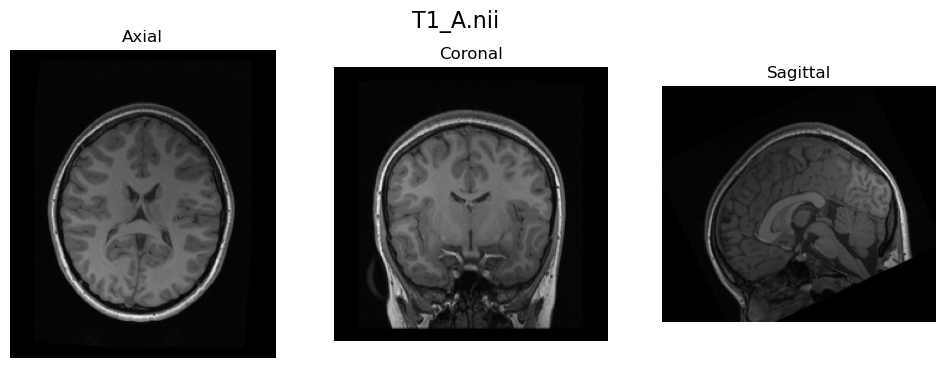

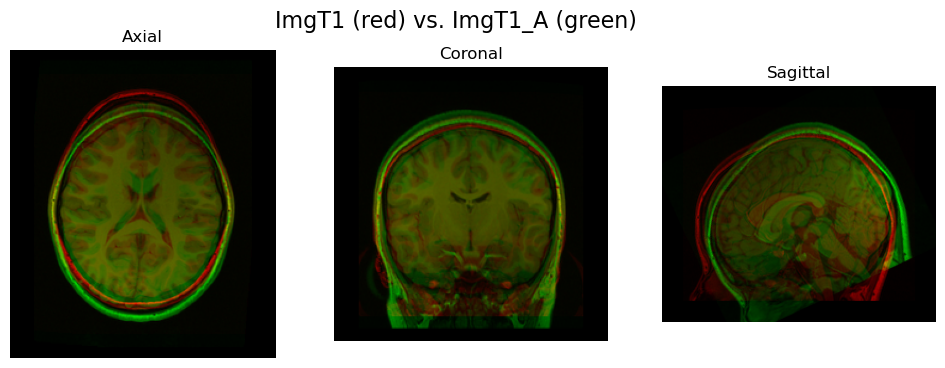

In [16]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

## Regsitration of a moving image to a fixed image
### Ex 5,6 and 7

**EX 5 find the best transformation of the moving image to the fixed image, moving image = ImgT1_A.nii and the fixed image ImgT1.nii** The new rotated image is named ImgT1_B.nii and the optimal affine transformation matrix text file is named A1.txt. You can try to modify the metric and optimizer step length.

In [17]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

0

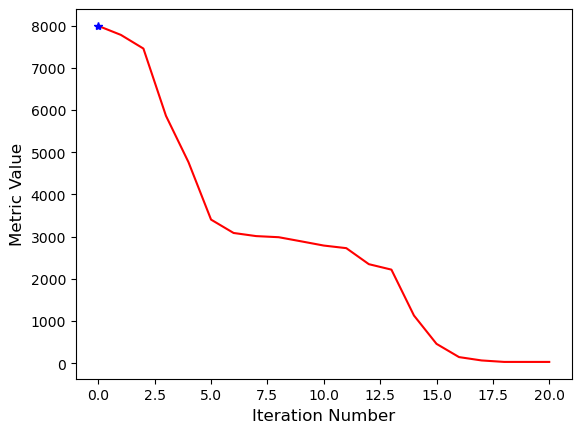

In [18]:
moving_image = ImgT1_A
fixed_image = vol_sitk
# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

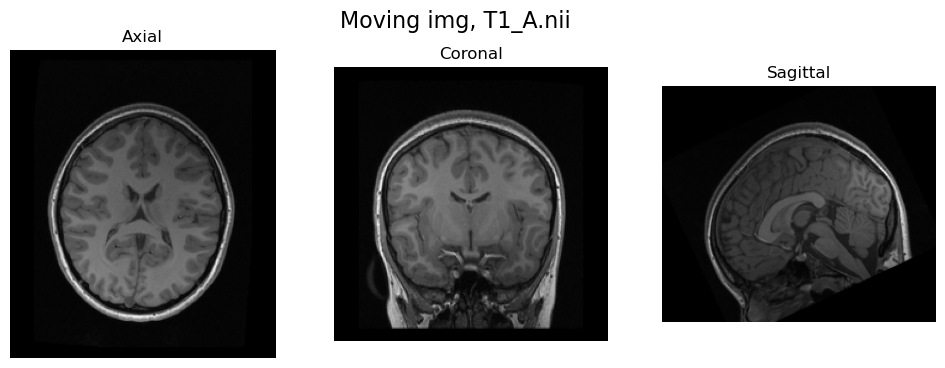

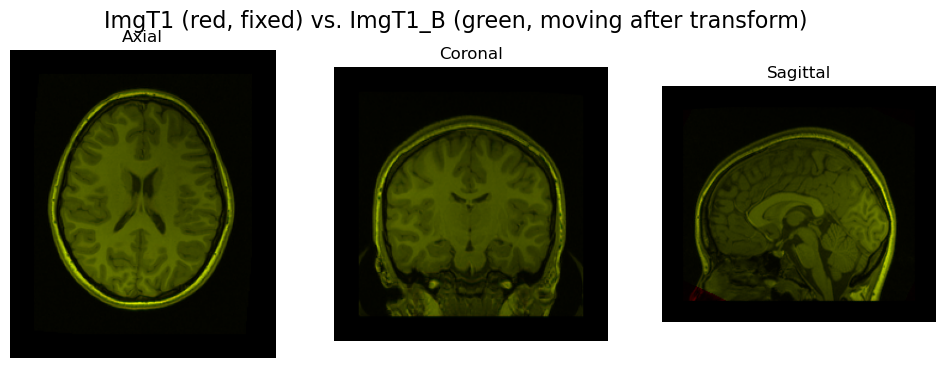

In [20]:
imshow_orthogonal_view(ImgT1_A, title='Moving img, T1_A.nii')
overlay_slices(vol_sitk, ImgT1_B, title = 'ImgT1 (red, fixed) vs. ImgT1_B (green, moving after transform)')

### Estimated transformation

In [28]:
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix() # Transform matrix
estimated_translation = tform_reg.GetNthTransform(0).GetTranslation() # Translation vector
params = tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

#Rounded to 3 decimal places

print(f"Estimated transform matrix: \n{np.round(params, 3)}")

Estimated transform matrix: 
[ 4.3600e-01 -0.0000e+00  0.0000e+00 -2.0000e-03  1.1167e+01  3.0628e+01]


In [29]:
#Transform from radians to degrees
np.rad2deg(params[0]) 

24.997228040977937

Very close to 25 degrees, the actual rotation

### Exercise 6

In [31]:
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

In [32]:
matrix_estimated

array([[ 9.99999999e-01, -2.87538444e-05, -2.46657836e-05,
        -1.58136929e-03],
       [ 1.56372919e-05,  9.06328232e-01, -4.22574415e-01,
         1.11673135e+01],
       [ 3.45059350e-05,  4.22574414e-01,  9.06328232e-01,
         3.06276210e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [33]:
matrix_applied

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.90630779,  0.42261826,  0.        ],
       [ 0.        , -0.42261826,  0.90630779,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [34]:
#Vs the applied
affine_1

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.90630779, -0.42261826,  0.        ],
       [ 0.        ,  0.42261826,  0.90630779,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [35]:
tform_reg.WriteTransform(dir_in + 'A1.tfm')
tform_loaded = sitk.ReadTransform(dir_in + 'A1.tfm')

### Ex 7 

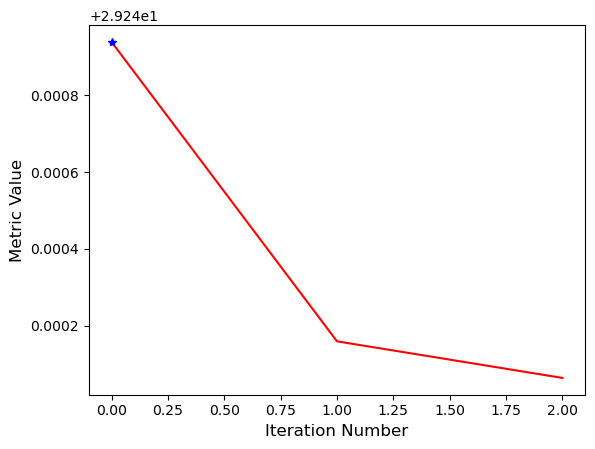

In [38]:
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

initTransform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

moving_image = ImgT1_A
fixed_image = vol_sitk
# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_C = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_C, dir_in + 'ImgT1_C.nii')

## Generate a series of rotated 3D images
**Exercise 8, 9**